#Installing Required Libraries

Install the necessary Python packages for the project.


In [2]:
!pip install torch
!pip install pytorch-crf
!pip install torchtext
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00


#Importing Libraries
Import the required libraries and modules for the project.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import numpy as np
from collections import defaultdict
import nltk


from torchcrf import CRF
from torchtext.vocab import GloVe

import matplotlib.pyplot as plt

#Downloading NLTK Resources

Download necessary resources from the NLTK package:

the punkt sentence tokenizer and the averaged_perceptron_tagger for part-of-speech (POS) tagging. These resources are essential for preprocessing text data.

In [4]:
# Downloading necessary NLTK resources for tokenization and POS tagging
nltk.download('punkt')  # Tokenizer for sentence splitting
nltk.download('averaged_perceptron_tagger')  # POS tagger
from nltk.tokenize import word_tokenize  # Tokenizer function

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#Setting Up the Device

Determine if a CUDA-capable GPU is available for PyTorch to use (cuda), otherwise defaults to using the CPU (cpu).

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.is_available())  # Check if CUDA (GPU support) is enabled

Using device: cuda
True


#Data Extraction Function

A function, extract_data, that reads text, slot tags, and labels from specified file paths. It also generates POS tags for each sentence, creating a comprehensive dataset for the model to train on. The function returns four lists containing sentences, slot tags, intent labels, and POS tags.

In [6]:
def extract_data(seq_in_path, seq_out_path, label_path):
    # Reading data from files
    with open(seq_in_path, 'r', encoding='utf-8') as seq_in_file, \
         open(seq_out_path, 'r', encoding='utf-8') as seq_out_file, \
         open(label_path, 'r', encoding='utf-8') as label_file:
        texts = [line.strip().split() for line in seq_in_file.readlines()]
        slot_tags = [line.strip().split() for line in seq_out_file.readlines()]
        labels = [line.strip() for line in label_file.readlines()]

    # Generating POS tags for each sentence
    pos_tags = [nltk.pos_tag(sentence) for sentence in texts]
    # Extracting just the POS tags
    pos_tags_only = [[tag for word, tag in sentence] for sentence in pos_tags]

    return texts, slot_tags, labels, pos_tags_only

#Data Preparation Function

prepare_data takes text data and converts words, slot tags, POS tags, and labels into numeric indices, facilitating their use in neural network models. It creates mappings (word_to_ix, tag_to_ix, pos_to_ix, label_to_ix) for each unique word, tag, POS tag, and label to an index.

In [7]:
def prepare_data(texts, slot_tags, pos_tags_only, labels):
    word_to_ix = {"<PAD>": 0}  # Mapping words to indices, with padding token
    tag_to_ix = {"<PAD>": 0}  # Mapping slot tags to indices
    pos_to_ix = {"<PAD>": 0}  # Mapping POS tags to indices
    label_to_ix = {"<PAD>": 0}  # Mapping labels to indices

    # Populating mappings
    for sentence in texts:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    for tags in slot_tags:
        for tag in tags:
            if tag not in tag_to_ix:
                tag_to_ix[tag] = len(tag_to_ix)
    for pos_sentence in pos_tags_only:
        for pos_tag in pos_sentence:
            if pos_tag not in pos_to_ix:
                pos_to_ix[pos_tag] = len(pos_to_ix)
    for label in labels:
        if label not in label_to_ix:
            label_to_ix[label] = len(label_to_ix)

    return word_to_ix, tag_to_ix, pos_to_ix, label_to_ix

#Dataset Object Definition

A custom PyTorch Dataset class, DatasetObj, to handle loading and batching the data efficiently. It includes the capability to work with text data, slot tags, POS tags, and labels. The class also defines a collate_fn method for batching, padding sequences to a uniform length within each batch.

In [8]:
class DatasetObj(Dataset):
    def __init__(self, texts, slot_tags, pos_tags, labels=None, word_to_ix=None, tag_to_ix=None, pos_to_ix=None):
        self.texts = texts  # Sentences
        self.slot_tags = slot_tags  # Slot tags for each token in sentences
        self.pos_tags = pos_tags  # POS tags for each token
        self.labels = labels  # Intent labels for sentences
        self.word_to_ix = word_to_ix  # Word to index mapping
        self.tag_to_ix = tag_to_ix  # Slot tag to index mapping
        self.pos_to_ix = pos_to_ix  # POS tag to index mapping
        # Converting texts and tags to their respective indices
        self.sentences = [[self.word_to_ix[word] for word in sentence] for sentence in texts]
        self.tags = [[self.tag_to_ix[tag] for tag in slot_tag] for slot_tag in slot_tags]
        self.pos = [[self.pos_to_ix[pos] for pos in pos_sentence] for pos_sentence in pos_tags]
        self.label_to_ix = {label: i for i, label in enumerate(set(labels))}
        self.labels_ix = [self.label_to_ix[label] for label in labels]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        sentence_tensor = torch.tensor(self.sentences[idx], dtype=torch.long)
        tags_tensor = torch.tensor(self.tags[idx], dtype=torch.long)
        pos_tensor = torch.tensor(self.pos[idx], dtype=torch.long)

        if self.labels is not None:
            label_tensor = torch.tensor(self.labels_ix[idx], dtype=torch.long)
            return sentence_tensor, tags_tensor, pos_tensor, label_tensor
        else:
            return sentence_tensor, tags_tensor, pos_tensor

    @staticmethod
    def collate_fn(batch):
        sentences, tags, pos_tags, *optional_labels = zip(*batch)
        sentences_padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
        tags_padded = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=0)
        pos_tags_padded = torch.nn.utils.rnn.pad_sequence(pos_tags, batch_first=True, padding_value=0)
        if optional_labels:
            labels = torch.tensor(optional_labels[0], dtype=torch.long)
            return sentences_padded, tags_padded, pos_tags_padded, labels
        else:
            return sentences_padded, tags_padded, pos_tags_padded

#Dataset Selection

Sets the dataset to use (atis or snips).

In [9]:
# Specify the dataset to use (e.g., "atis" or "snips")
ds = "snips"

#Path Specification

Specifies the file paths for the training, development, and test datasets.

In [10]:
# Paths for the training dataset
train_seq_in_path = f'/data/{ds}/train/seq.in'
train_seq_out_path = f'/data/{ds}/train/seq.out'
train_label_path = f'/data/{ds}/train/label'

# Paths for the development dataset
dev_seq_in_path = f'/data/{ds}/dev/seq.in'
dev_seq_out_path = f'/data/{ds}/dev/seq.out'
dev_label_path = f'/data/{ds}/dev/label'

# Paths for the test dataset
test_seq_in_path = f'/data/{ds}/test/seq.in'
test_seq_out_path = f'/data/{ds}/test/seq.out'
test_label_path = f'/data/{ds}/test/label'

#Data Loading

Loads the training, development, and test data using the extract_data function defined earlier. It concatenates all texts, slot tags, POS tags, and labels from the different splits to create comprehensive mappings for the entire dataset.

In [11]:
# Extract sentences, slot tags, labels, and POS tags from the specified dataset files
train_texts, train_slot_tags, train_labels, train_pos_tags = extract_data(train_seq_in_path, train_seq_out_path, train_label_path)
dev_texts, dev_slot_tags, dev_labels, dev_pos_tags = extract_data(dev_seq_in_path, dev_seq_out_path, dev_label_path)
test_texts, test_slot_tags, test_labels, test_pos_tags = extract_data(test_seq_in_path, test_seq_out_path, test_label_path)

# Combine texts, slot tags, and POS tags from all data splits for vocabulary creation
all_texts = train_texts + dev_texts + test_texts
all_slot_tags = train_slot_tags + dev_slot_tags + test_slot_tags
all_pos_tags = train_pos_tags + dev_pos_tags + test_pos_tags
all_labels = train_labels + dev_labels + test_labels

# Prepare data by creating mappings from words, tags, and labels to indices
word_to_ix, tag_to_ix, pos_to_ix, label_to_ix = prepare_data(all_texts, all_slot_tags, all_pos_tags, all_labels)

# Calculate the number of unique labels
num_labels = len(set(all_labels))

#GloVe Embeddings Initialization

Initializes the GloVe word embeddings from the torchtext library, specifying the 6B version with 300-dimensional vectors. These pre-trained embeddings will be used to represent words numerically.

In [12]:
# Load pre-trained GloVe word embeddings with 300 dimensions
glove = GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:52<00:00, 7590.57it/s]


#embedding Matrices Creation

Defines functions to create embedding matrices for both words (create_embedding_matrix) and POS tags (create_pos_embedding_matrix) based on the mappings created earlier. These matrices serve as the initial weights for the embedding layers in the model.

In [13]:
def create_embedding_matrix(word_to_ix, glove):
    """Creates an embedding matrix for the vocabulary."""
    embedding_dim = glove.dim
    embeddings = torch.randn(len(word_to_ix), embedding_dim)
    embeddings[word_to_ix["<PAD>"]] = torch.zeros(embedding_dim)
    for word, ix in word_to_ix.items():
        if word in glove.stoi:
            embeddings[ix] = glove[word]
    return embeddings


def create_pos_embedding_matrix(pos_to_ix, pos_embedding_dim):
    """Creates an embedding matrix for POS tags."""
    embeddings = torch.randn(len(pos_to_ix), pos_embedding_dim)
    embeddings[pos_to_ix["<PAD>"]] = torch.zeros(pos_embedding_dim)  # Zero vector for padding
    return embeddings


Sentence-Level Prediction Module

Defines a neural network module, SentenceLevelPrediction, that takes LSTM outputs, applies adaptive max pooling and a linear layer to predict sentence-level intents or other attributes.

In [14]:
class SentenceLevelPrediction(nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super(SentenceLevelPrediction, self).__init__()
        self.pooling = nn.AdaptiveMaxPool1d(1)  # Adaptive max pooling to a single value
        self.fc = nn.Linear(hidden_dim, num_labels)  # Linear layer for label prediction

    def forward(self, lstm_out):
        # Apply adaptive max pooling and linear layer to LSTM output for sentence-level prediction
        pooled = self.pooling(lstm_out.transpose(1, 2)).squeeze(-1)
        logits = self.fc(pooled)
        return torch.sigmoid(logits)  # Use sigmoid for binary/multi-label classification

#Discriminator Definition

Defines a Discriminator neural network for adversarial training. It aims to distinguish between real and fake (shuffled) sequences based on their representations, contributing to the mutual information maximization component of the model.

In [15]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim * 2, 128)  # First linear layer
        self.fc2 = nn.Linear(128, 1)  # Second linear layer for binary classification

    def forward(self, x):
        # Apply ReLU activation followed by sigmoid for binary classification
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

#Main Model Definition

Defines the main model, Model, incorporating word and POS tag embeddings, an LSTM for sequence modeling, a CRF for sequence labeling, and various components for adversarial training and auxiliary tasks.

In [16]:
class Model(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, pretrained_word_embeddings=None, pretrained_pos_embeddings=None, pos_vocab_size=None, pos_embedding_dim=None, num_labels=None, num_lstm_layers=1):
        super(Model, self).__init__()

        # For word embeddings
        self.word_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # For POS embeddings
        self.pos_embedding = nn.Embedding(pos_vocab_size, pos_embedding_dim)

        # Adjust LSTM input size to sum of word and POS embedding dimensions
        lstm_input_dim = embedding_dim + pos_embedding_dim
        self.lstm = nn.LSTM(lstm_input_dim, hidden_dim // 2, num_layers=num_lstm_layers, bidirectional=True)

        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

        # Adversarial MI Estimation Components
        self.discriminator = Discriminator(hidden_dim)

        # Initialize the sentence-level prediction module if num_labels is provided
        self.sentence_level_predictor = nn.Linear(hidden_dim, num_labels)

        # Auxiliary components
        self.word_context_classifier = nn.Linear(hidden_dim, tagset_size)

        self.context2label = nn.Linear(hidden_dim, tagset_size)

        self.sentence_label_classifier = nn.Linear(hidden_dim, tagset_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, sentence,pos_tags):
        # Embedding lookup and combination for input sequences.
        word_embeds = self.word_embedding(sentence)
        pos_embeds = self.pos_embedding(pos_tags)
        embeds = torch.cat((word_embeds, pos_embeds), dim=-1)
        # Process sequence through LSTM.
        lstm_out, _ = self.lstm(embeds)
        # Map LSTM outputs to tag space and generate sentence-level predictions.
        tag_space = self.hidden2tag(lstm_out)
        sentence_representation = torch.mean(lstm_out, dim=1)
        sentence_level_logits = None
        if hasattr(self, 'sentence_level_predictor'):
            sentence_level_logits = torch.sigmoid(self.sentence_level_predictor(sentence_representation))

        word_labels_from_context = self.context2label(torch.mean(lstm_out, dim=1))

        return tag_space, lstm_out, sentence_level_logits, word_labels_from_context

    def compute_discriminator_loss(self, lstm_out, device):
        batch_size, seq_len, hidden_dim = lstm_out.size()

        # context vector generation
        context_vectors = lstm_out.mean(dim=1, keepdim=True).expand(-1, seq_len, -1)

        joint_samples = torch.cat((lstm_out, context_vectors), dim=-1)

        # Randomly shuffle context vectors
        idx = torch.randperm(batch_size)
        marginal_context_vectors = context_vectors[idx]

        marginal_samples = torch.cat((lstm_out, marginal_context_vectors), dim=-1)

        # Compute discriminator loss
        true_preds = self.discriminator(joint_samples.view(-1, hidden_dim * 2))
        false_preds = self.discriminator(marginal_samples.view(-1, hidden_dim * 2))

        true_labels = torch.ones(true_preds.size(), device=device)
        false_labels = torch.zeros(false_preds.size(), device=device)

        disc_loss = F.binary_cross_entropy(torch.cat((true_preds, false_preds), dim=0),
                                           torch.cat((true_labels, false_labels), dim=0))

        return disc_loss

    def compute_auxiliary_losses(self, lstm_out, tags, sentence_lengths, labels=None):
        # Initialization of loss components
        auxiliary_loss = 0

        lstm_out_flat = lstm_out.contiguous().view(-1, lstm_out.shape[-1])
        tags_flat = tags.contiguous().view(-1)
        word_context_logits = self.word_context_classifier(lstm_out_flat)
        word_context_loss = nn.CrossEntropyLoss()(word_context_logits, tags_flat)
        auxiliary_loss += word_context_loss

        if labels is not None and hasattr(self, 'sentence_level_predictor'):
            sentence_representation = torch.mean(lstm_out, dim=1)
            sentence_label_logits = self.sentence_level_predictor(sentence_representation)
            sentence_label_loss = nn.BCEWithLogitsLoss()(sentence_label_logits, labels.float())
            auxiliary_loss += sentence_label_loss

        return auxiliary_loss


    def loss(self, tag_space, lstm_out, sentence_level_logits, word_labels_from_context, tags, alpha, beta, gamma, labels=None):
        crf_loss = -self.crf(tag_space, tags, mask=(tags != 0), reduction='mean')
        disc_loss = self.compute_discriminator_loss(lstm_out, device)

        auxiliary_loss = 0

        sentence_level_loss = F.cross_entropy(sentence_level_logits, labels)
        auxiliary_loss += sentence_level_loss

        total_loss = alpha * crf_loss + beta * disc_loss + gamma * auxiliary_loss
        return total_loss

    def predict(self, sentences, pos_tags):
        tag_space, _, sentence_level_logits, _ = self.forward(sentences, pos_tags)
        tags = self.crf.decode(tag_space)  # Slot predictions
        intents = torch.argmax(sentence_level_logits, dim=1)  # Intent predictions

        return tags, intents

#Model Training and Validation

Implements the function train_and_validate_model for training the model on the training dataset and validating its performance on the development dataset. It optimizes the model parameters based on a composite loss function and saves the best-performing model.

In [17]:
def train_and_validate_model(model, train_loader, dev_loader, optimizer, num_epochs, device, alpha, beta, gamma):
    best_validation_loss = float('inf')  # Initialize the best validation loss to infinity for comparison later.

    # Initialize lists to store per-epoch metrics for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):  # Iterate over the specified number of epochs.
        model.train()  # Set the model to training mode.
        total_train_loss = 0  # Initialize total training loss for the epoch.

        # Training phase
        for sentences, pos_tags, tags, labels in train_loader:  # Loop through batches in the training data loader.
            # Move data to the specified device (GPU or CPU).
            sentences, pos_tags, tags = sentences.to(device), pos_tags.to(device), tags.to(device)
            labels = labels.to(device) if labels is not None else None  # Labels might not always be provided.

            optimizer.zero_grad()  # Clear gradients before computing them.

            # Forward pass through the model.
            tag_space, lstm_out, sentence_level_logits, word_labels_from_context = model(sentences, pos_tags)

            # Calculate loss using the model's custom loss function.
            loss = model.loss(tag_space=tag_space, lstm_out=lstm_out, sentence_level_logits=sentence_level_logits,
                              word_labels_from_context=word_labels_from_context, tags=tags, alpha=alpha, beta=beta, gamma=gamma, labels=labels)

            loss.backward()  # Perform backpropagation based on the loss.
            optimizer.step()  # Update model parameters.

            total_train_loss += loss.item()  # Accumulate total loss for the epoch.

        avg_train_loss = total_train_loss / len(train_loader)  # Calculate average training loss.
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode.

        total_validation_loss = 0
        total_correct_slots = 0
        total_correct_intents = 0
        total_slots = 0
        total_intents = 0

        total_validation_loss = 0  # Initialize total validation loss for the epoch.

        with torch.no_grad():  # Deactivate gradient calculations.
            for sentences, pos_tags, tags, labels in dev_loader:  # Loop through batches in the development (validation) data loader.
                # Move data to the device.
                sentences, pos_tags, tags = sentences.to(device), pos_tags.to(device), tags.to(device)
                labels = labels.to(device) if labels is not None else None

                # Forward pass through the model without computing gradients.
                tag_space, lstm_out, sentence_level_logits, word_labels_from_context = model(sentences, pos_tags)

                # Calculate validation loss.
                val_loss = model.loss(tag_space=tag_space, lstm_out=lstm_out, sentence_level_logits=sentence_level_logits,
                                      word_labels_from_context=word_labels_from_context, tags=tags, alpha=alpha, beta=beta, gamma=gamma, labels=labels)
                total_validation_loss += val_loss.item()

                # For metrics calculation, adjust the following logic based on your model's specifics
                slot_predictions = torch.argmax(tag_space, -1)
                intent_predictions = torch.argmax(sentence_level_logits, -1)

                total_correct_slots += (slot_predictions == tags).sum().item()
                total_correct_intents += (intent_predictions == labels).sum().item()
                total_slots += tags.numel()
                total_intents += labels.size(0)

        avg_validation_loss = total_validation_loss / len(dev_loader)  # Calculate average validation loss.
        val_losses.append(avg_validation_loss)

        # Print training and validation loss for the epoch.
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}")

        # Check if the current epoch's validation loss is the best so far.
        if avg_validation_loss < best_validation_loss:
            best_validation_loss = avg_validation_loss  # Update best validation loss.
            # Save the model state with the best validation loss.
            torch.save(model.state_dict(), 'model_best_validation.pth')
            print("Model saved with improved validation loss.")

    # Return the best validation loss achieved.
    return train_losses, val_losses, best_validation_loss

#Model Evaluation

Defines evaluate_model, a function to evaluate the trained model on a test dataset. It calculates and prints out accuracy, precision, recall, and F1 scores for both slot filling and intent detection tasks.

In [18]:
def evaluate_model(model, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.to(device)
    model.eval()

    true_tags, pred_tags = [], []
    true_intents, pred_intents = [], []

    with torch.no_grad():
        for sentences, pos_tags, tags, intent_labels in test_loader:
            sentences, pos_tags, tags, intent_labels = sentences.to(device), pos_tags.to(device), tags.to(device), intent_labels.to(device)

            # Assuming model.predict now also returns intent predictions
            predicted_tags_batch, predicted_intents_batch = model.predict(sentences, pos_tags)

            # Process slot filling predictions
            predicted_tags_batch = torch.tensor(predicted_tags_batch, dtype=torch.long, device=device)
            predicted_tags_batch = predicted_tags_batch.view(-1).cpu().numpy()
            true_tags.extend(tags.view(-1).cpu().numpy())
            pred_tags.extend(predicted_tags_batch)

            # Process intent detection predictions
            # Assuming predicted_intents_batch is a tensor of predicted intent indices
            pred_intents.extend(predicted_intents_batch.cpu().numpy())
            true_intents.extend(intent_labels.cpu().numpy())

    # Calculate and print metrics for slot filling
    accuracy_slots = accuracy_score(true_tags, pred_tags)
    precision_slots, recall_slots, f1_slots, _ = precision_recall_fscore_support(true_tags, pred_tags, average='macro', zero_division=0)
    print(f"Slot Filling - Accuracy: {accuracy_slots:.4f}, Precision: {precision_slots:.4f}, Recall: {recall_slots:.4f}, F1: {f1_slots:.4f}")

    # Calculate and print metrics for intent detection
    accuracy_intents = accuracy_score(true_intents, pred_intents)
    precision_intents, recall_intents, f1_intents, _ = precision_recall_fscore_support(true_intents, pred_intents, average='macro', zero_division=0)
    print(f"Intent Detection - Accuracy: {accuracy_intents:.4f}, Precision: {precision_intents:.4f}, Recall: {recall_intents:.4f}, F1: {f1_intents:.4f}")

#Maximum POS Vocabulary Size Calculation

Calculates the maximum POS tag index across all datasets to ensure the POS embedding layer accommodates all tags. This function helps define the correct size for the POS tag embedding matrix.

In [19]:
def calculate_max_pos_vocab_size(data_loaders):
    max_index = -1
    for loader in data_loaders:
        for batch in loader:
            # Use index-based access for pos_tags
            pos_tags = batch[1]
            current_max = pos_tags.max().item()
            max_index = max(max_index, current_max)
    # Since indices are zero-based, add 1 to get the correct vocabulary size.
    pos_vocab_size = max_index + 1
    return pos_vocab_size


#Plotting function

In [20]:
def plot_loss_graph(train_losses, val_losses):
    # Determine the maximum length among the loss metrics to set up the x-axis
    max_length = max(len(train_losses), len(val_losses))

    # Generate an x-axis based on the maximum length
    epochs = np.arange(1, max_length + 1)

    # Set up the plotting
    plt.figure(figsize=(10, 6))

    # Plot training and validation losses
    plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
    plt.plot(epochs[:len(val_losses)], val_losses, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#Model Hyperparameters and Initialization

Sets various hyperparameters for the model, initializes the word and POS tag embedding matrices, and creates instances of the training, development, and test datasets and their corresponding data loaders.

In [21]:
# Dimension for POS tag embeddings
pos_embedding_dim = 50
pretrained_embeddings = create_embedding_matrix(word_to_ix, glove)
pos_embeddings = create_pos_embedding_matrix(pos_to_ix, pos_embedding_dim)

max_index = max(pos_to_ix.values())

vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)

embedding_dim = glove.dim
hidden_dim = 100

learning_rate = 0.001
num_epochs = 15
batch_size = 1

num_lstm_layers = 2

tradeoff_params = {'alpha': .1, 'beta': .1, 'gamma': .1}

best_val_loss = float('inf')

#Data Loader Creation

Instantiates PyTorch DataLoader objects for the training, development, and test datasets, specifying batch sizes and whether to shuffle the data. These loaders streamline the process of feeding data into the model during training and evaluation.

In [22]:
train_dataset = DatasetObj(train_texts, train_slot_tags, train_pos_tags, train_labels, word_to_ix, tag_to_ix, pos_to_ix)
dev_dataset = DatasetObj(dev_texts, dev_slot_tags, dev_pos_tags, dev_labels, word_to_ix, tag_to_ix, pos_to_ix)
test_dataset = DatasetObj(test_texts, test_slot_tags, test_pos_tags, test_labels, word_to_ix, tag_to_ix, pos_to_ix)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=DatasetObj.collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=DatasetObj.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=DatasetObj.collate_fn)


#Model Training and Optimizer Initialization

Initializes the model with the specified vocabulary sizes, embedding dimensions, and other hyperparameters. It also creates an optimizer for updating the model's weights based on the computed gradients during training.

Calls the train_and_validate_model function to train the model and print the best validation loss achieved.

In [23]:
pos_vocab_size = calculate_max_pos_vocab_size([train_loader, dev_loader, test_loader])
model = Model(vocab_size=vocab_size,
              tagset_size=tagset_size,
              embedding_dim=embedding_dim,
              hidden_dim=hidden_dim,
              pretrained_word_embeddings=pretrained_embeddings,
              pretrained_pos_embeddings=pos_embeddings,
              pos_vocab_size=pos_vocab_size,
              pos_embedding_dim=pos_embedding_dim,
              num_labels=num_labels,
              num_lstm_layers=num_lstm_layers).to(device)

# Train the model with the specified hyperparameters and data loaders.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer setup.
# Call the training and validation function, passing the necessary arguments.
train_losses, val_losses, val_loss = train_and_validate_model(
    model, train_loader, dev_loader, optimizer, num_epochs, device, **tradeoff_params)
# Output the best validation loss achieved during training.
if val_loss < best_val_loss:
   best_val_loss = val_loss
print(f"Best Validation Loss: {best_val_loss}")

Epoch 1, Train Loss: 0.5798, Validation Loss: 0.4463
Model saved with improved validation loss.
Epoch 2, Train Loss: 0.3927, Validation Loss: 0.4326
Model saved with improved validation loss.
Epoch 3, Train Loss: 0.3431, Validation Loss: 0.4336
Epoch 4, Train Loss: 0.3168, Validation Loss: 0.4449
Epoch 5, Train Loss: 0.3035, Validation Loss: 0.4544
Epoch 6, Train Loss: 0.2959, Validation Loss: 0.4617
Epoch 7, Train Loss: 0.2906, Validation Loss: 0.4689
Epoch 8, Train Loss: 0.2872, Validation Loss: 0.4738
Epoch 9, Train Loss: 0.2847, Validation Loss: 0.4790
Epoch 10, Train Loss: 0.2823, Validation Loss: 0.4750
Epoch 11, Train Loss: 0.2809, Validation Loss: 0.4821
Epoch 12, Train Loss: 0.2798, Validation Loss: 0.5000
Epoch 13, Train Loss: 0.2789, Validation Loss: 0.4934
Epoch 14, Train Loss: 0.2783, Validation Loss: 0.4972
Epoch 15, Train Loss: 0.2773, Validation Loss: 0.4952
Best Validation Loss: 0.43255135308418957


#Plot train and validation losses

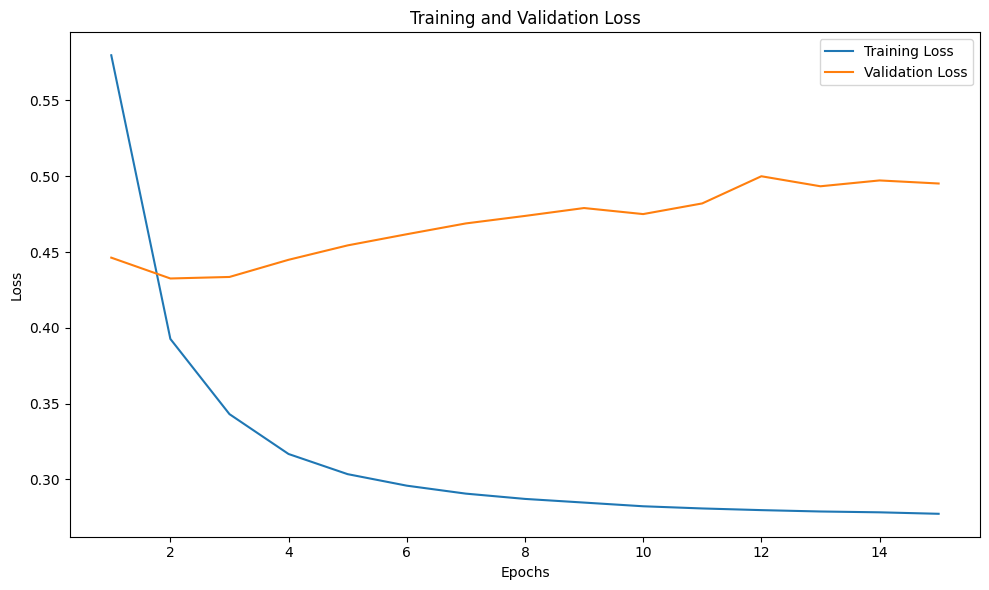

In [24]:
plot_loss_graph(train_losses, val_losses)

#Model Testing

Evaluates the trained model's performance on the test dataset using the evaluate_model function.

In [25]:
evaluate_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:519.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Slot Filling - Accuracy: 0.9108, Precision: 0.7857, Recall: 0.7498, F1: 0.7563
Intent Detection - Accuracy: 0.9886, Precision: 0.9887, Recall: 0.9883, F1: 0.9884
